We studied the effect of changing the composition of the gas phase, namely
partial pressures for $O_2$ and $CO$, in the $CO_2$ Turnover frequency (TOF),
in some of the pyZacros tutorials for the Ziff-Gulari-Barshad model (see
especially **Phase Transitions in the ZGB model** and
**Ziff-Gulari-Barshad model: Steady State Conditions**). We used an evenly
distributed grid on the $CO$ gas phase molar fraction in those tutorials.
From the results, it is possible to see that, typically, the lower the $CO_2$
production, the more difficult it is to achieve a steady state (except when
$CO_2$ production is zero, likely because the surface got poisoned, which
makes the calculation finish quickly). This means that most of the computational
time is spent on points that are not as interesting from a catalytic perspective
as points with higher CO2 production. Thus, it would be ideal an automatically
generate more points in the more interesting areas to reduce the overall
computational cost of these property scans. This is precisely why the
**Adaptive Design Procedure (ADP)** was created.

The ADP was created to generate training data for Machine Learning (ML) algorithms,
with a particular emphasis on approximating computationally-intensive
first-principles kinetic models in catalysis. The procedure is based on
function topology and behavior, with the discrete gradient and relative
importance of the independent variables calculated. See more details in the
original publication [Chem. Eng. J 400, (2020), 125469](https://doi.org/10.1016/j.cej.2020.125469).
The authors demonstrate that the procedure could design a dataset (achieving
the same accuracy) using only between 60 and 80% fewer data points as are
needed in an evenly distributed grid. Furthermore, the ADP generates a
**Surrogate Model** of the data based on ML techniques,
allowing interpolation of points not included in the original data set,
which is critical for multiscale simulations of complex chemical reactors.

In this tutorial, we will likewise examine the effects of altering the gas
phase's composition in the $CO_2$ Turnover frequency (TOF) in the ZGB model,
but we will do so while utilizing the ADP to both suggest the values of the
$CO$ molar fractions to evaluate and generate a surrogate model for this solution.
In practice, the surrogate model is a [PKL file](https://docs.python.org/3/library/pickle.html)
that contains all of the parameters of the ML model, allowing it to be regenerated
and used subsequently. The main goal of this tutorial is to obtain this file.

First of all, we must install the package **adaptiveDesignProcedure**. You
can either follow the procedure described in its GitHub repository
[https://github.com/mbracconi/adaptiveDesignProcedure](https://github.com/mbracconi/adaptiveDesignProcedure),
or if you are using AMS, you can do it as follows by typing in a terminal:
```
$ amspackages install adaptivedesignprocedure
```

Now, let's start with the script. Foremost, we import all packages we need:

In [1]:
import multiprocessing
import numpy

import scm.plams
import scm.pyzacros as pz
import scm.pyzacros.models

import adaptiveDesignProcedure as adp
import warnings; warnings.simplefilter('ignore', UserWarning)

The ``import warning`` line is just needed to get clean output messages further down.

The ADP method needs a function that generates the data for the model;
we named it ``get_rate()``. This function accepts a single argument,
a 2d-array containing the conditions to be computed with the shape
``(number of conditions, number of input variables)``, and returns a
2d-array containing the calculated values with the shape
``(number of conditions, number of output variables)``. The number of
conditions will be determined on the fly by the ADP. On the contrary,
we must decide on the number of input and output variables. In our
example, we have ``one input variable``, the molar fraction of CO, and
``three output variables``, the average coverage for $O*$ and $CO*$
and the $CO_2$ TOF.

This ``get_rate()`` function performs a ``ZacrosParametersScanJob``
calculation. To follow the details, please refer to the example
**Phase Transitions in the ZGB model**. In a nutshell, it configures
the ``ZacrosJob`` calculation with the ZGB predefined model. Then it
configures and runs the ``ZacrosParametersScanJob``, using the
``ZacrosJob`` defined before as the reference and setting the $CO$
molar fraction equal to the conditions established by the ADP. Finally,
it retrieves the results for each condition by calling the
``turnover frequency()`` and ``average coverage()`` functions and
storing them in the output array in the correct order.

In [2]:
def get_rate( conditions ):
    
    print("")
    print("  Requesting:")
    for cond in conditions:
        print("    x_CO = ", cond[0])
    print("")
    
    #---------------------------------------
    # Zacros calculation
    #---------------------------------------
    zgb = pz.models.ZiffGulariBarshad()

    z_sett = pz.Settings()
    z_sett.random_seed = 953129
    z_sett.temperature = 500.0
    z_sett.pressure = 1.0
    z_sett.species_numbers = ('time', 0.1)
    z_sett.max_time = 10.0

    z_job = pz.ZacrosJob( settings=z_sett, lattice=zgb.lattice,
                          mechanism=zgb.mechanism,
                          cluster_expansion=zgb.cluster_expansion )

    #---------------------------------------
    # Parameters scan calculation
    #---------------------------------------
    ps_params = pz.ZacrosParametersScanJob.Parameters()
    ps_params.add( 'x_CO', 'molar_fraction.CO', [ cond[0] for cond in conditions ] )
    ps_params.add( 'x_O2', 'molar_fraction.O2', lambda params: 1.0-params['x_CO'] )

    ps_job = pz.ZacrosParametersScanJob( reference=z_job, parameters=ps_params )

    #---------------------------------------
    # Running the calculations
    #---------------------------------------
    results = ps_job.run()
    
    if not results.job.ok():
        print('Something went wrong!')

    #---------------------------------------
    # Collecting the results
    #---------------------------------------
    data = numpy.nan*numpy.empty((len(conditions),3))
    if( results.job.ok() ):
        results_dict = results.turnover_frequency()
        results_dict = results.average_coverage( last=20, update=results_dict )

        for i in range(len(results_dict)):
            data[i,0] = results_dict[i]['average_coverage']['O*']
            data[i,1] = results_dict[i]['average_coverage']['CO*']
            data[i,2] = results_dict[i]['turnover_frequency']['CO2']

    return data

Now, let's look at the script's main part.

As usual, we initialize the pyZacros environment:

In [3]:
scm.pyzacros.init()

PLAMS working folder: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir


We'll use the ``plams.JobRunner`` class, which easily allows us to run as many parallel
instances as we request. In this case, we choose to use the maximum number of
simultaneous processes (``maxjobs``) equal to the number of processors in the
machine. Additionally, by setting ``nproc =  1`` we establish that only one
processor will be used for each zacros instance. 

In [4]:
maxjobs = multiprocessing.cpu_count()
scm.plams.config.default_jobrunner = scm.plams.JobRunner(parallel=True, maxjobs=maxjobs)
scm.plams.config.job.runscript.nproc = 1
print('Running up to {} jobs in parallel simultaneously'.format(maxjobs))

Running up to 8 jobs in parallel simultaneously


Firstly, we must define the input and output variables. As previously stated, for
the input variables, we only have the molar fraction of CO (``x_CO``). In terms of
ADP, we must provide a name as well as a range to cover during the execution,
ranging from ``min`` to ``max`` and beginning with ``num`` evenly spaced samples.
Regarding the output variables, we have three: the average coverage for $O*$ and
$CO*$, as well as the $CO_2$ TOF. For them, in ADP, we only need to provide their
names (``ac_O``, ``ac_CO``, ``TOF_CO2``). Notice these names are arbitrary, and
they do not have any effect on the final results. However, the number of input
and output variables should be in correspondence with the array sizes used in the
``get_rate()`` function.

In [5]:
input_var = ( { 'name':'x_CO', 'min':0.2, 'max':0.8, 'num':5 }, )

output_var = ( {'name':'ac_O'},
               {'name':'ac_CO'},
               {'name':'TOF_CO2'}, )

Then, we create an ``adaptativeDesignProcedure`` object by calling its constructor,
which needs the input and output variables, the function to calculate the rates
``get_rates``. Additionally, for convenience, we set the output directory as a
subdirectory of the pyZacros working directory and set the random seed
(``randomState``) to get reproducible results. The last two parameters are optional.
It is also possible to provide several parameters to control the algorithm using
the keyword ``algorithmParams''. But we will get back to that later.

In [6]:
adpML = adp.adaptiveDesignProcedure( input_var, output_var, get_rate,
                                     outputDir=scm.pyzacros.workdir()+'/adp.results',
                                     randomState=10 )


------ Adaptive generation of Training Data for Machine Learning ------

Input parameters:
  * Forest file: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir/adp.results/ml_ExtraTrees.pkl
  * Training file: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir/adp.results/tmp/train.dat
  * Figure path: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir/adp.results/figures
  * Plotting enabled: False
  * Boruta as feature selector: True
  * Use Weak Support Var in Boruta:True

  * Forest parameters:
    {
        Ntree: 200
        tps: 1
        fraction: 0.7
    }

  * Algorithm parameters:
    {
        dth: 0.1
        d2th: 0.9
        VIth: 0.15
        errTh: 1e-06
        OOBth: 0.05
        RADth: 10
        maxTDSize: 5000
        AbsOOBTh: 0.2
    }


  * Variables information:
    {
        name: x_CO
        min: 0.2
        max: 0.8
        num: 5
    }


  * Tabulation information:
    {
        name: ac_O
    

Now, we begin the calculation by invoking the method ``createTrainingDataAndML()``,
which, as the name implies, generates the training data as well as the surrogate model
(or ML model). The program runs several cycles, and for each cycle,
increases the number of points and calls the "get rate()" function to evaluate them.
When the Relative Approximation Error and the Out-Of-Bag error are less than
``algorithmParams['RADth']`` (default=10%) and ``algorithmParams['OOBth']`` (default=0.05),
respectively, the calculation converges. See the original ADP documentation for
more details.

In [7]:
adpML.createTrainingDataAndML()


------------------ Iterative Species Points Addition ------------------

  * Tabulation Variables: ac_O

    * Iteration: 0
      --------------------------- 
      Points per species :5
      ---------------------------
      Total number of points: 5

  Requesting:
    x_CO =  0.2
    x_CO =  0.35000000000000003
    x_CO =  0.5
    x_CO =  0.6500000000000001
    x_CO =  0.8

[02.02|22:51:12] JOB plamsjob STARTED
[02.02|22:51:12] Waiting for job plamsjob to finish
[02.02|22:51:12] JOB plamsjob RUNNING
[02.02|22:51:12] JOB plamsjob/ps_cond000 STARTED
[02.02|22:51:12] JOB plamsjob/ps_cond001 STARTED
[02.02|22:51:12] JOB plamsjob/ps_cond002 STARTED
[02.02|22:51:12] JOB plamsjob/ps_cond003 STARTED
[02.02|22:51:12] JOB plamsjob/ps_cond004 STARTED
[02.02|22:51:12] JOB plamsjob/ps_cond000 RUNNING
[02.02|22:51:12] JOB plamsjob/ps_cond002 RUNNING
[02.02|22:51:12] JOB plamsjob/ps_cond001 RUNNING
[02.02|22:51:13] JOB plamsjob/ps_cond003 RUNNING
[02.02|22:51:13] JOB plamsjob/ps_cond004 RUNNING
[

If the execution got up to this point, everything worked as expected. Hooray!

The results are then collected by accessing the ``trainingData`` attribute of the
``adpML`` object, and they are presented nicely in a table in the lines that follow.

In [8]:
x_CO,ac_O,ac_CO,TOF_CO2 = adpML.trainingData.T

print( "-------------------------------------------------" )
print( "%4s"%"cond", "%8s"%"x_CO", "%10s"%"ac_O", "%10s"%"ac_CO", "%12s"%"TOF_CO2" )
print( "-------------------------------------------------" )
for i in range(len(x_CO)):
    print( "%4d"%i, "%8.3f"%x_CO[i], "%10.6f"%ac_O[i], "%10.6f"%ac_CO[i], "%12.6f"%TOF_CO2[i] )

-------------------------------------------------
cond     x_CO       ac_O      ac_CO      TOF_CO2
-------------------------------------------------
   0    0.200   0.998060   0.000000     0.049895
   1    0.350   0.974020   0.000200     0.273811
   2    0.359   0.960800   0.000200     0.310947
   3    0.369   0.938580   0.000360     0.403137
   4    0.388   0.925940   0.000260     0.462316
   5    0.397   0.887160   0.001060     0.629684
   6    0.406   0.879640   0.000560     0.664653
   7    0.416   0.854660   0.001520     0.759789
   8    0.425   0.802920   0.002940     0.902253
   9    0.434   0.796640   0.002460     0.975221
  10    0.444   0.770360   0.003760     1.129684
  11    0.453   0.772080   0.003540     1.167158
  12    0.463   0.734200   0.004960     1.336484
  13    0.472   0.701580   0.009360     1.555474
  14    0.481   0.643280   0.011700     1.741516
  15    0.491   0.586160   0.016680     1.960968
  16    0.500   0.568160   0.018740     2.108442
  17    0.509   0.

The above results are the final aim of the calculation. However, we
can take advantage of python libraries to visualize them. Here, we
use matplotlib. Please check the matplotlib documentation for more
details at [matplotlib](https://matplotlib.org/). The following lines
of code allow visualizing the effect of changing the $CO$ molar
fraction on the average coverage of $O*$ and $CO*$ and the production
rate of $CO_2$. In the Figure, we show the training data generated by
the Zacros model as points and the Surrogate Model's prediction as lines.

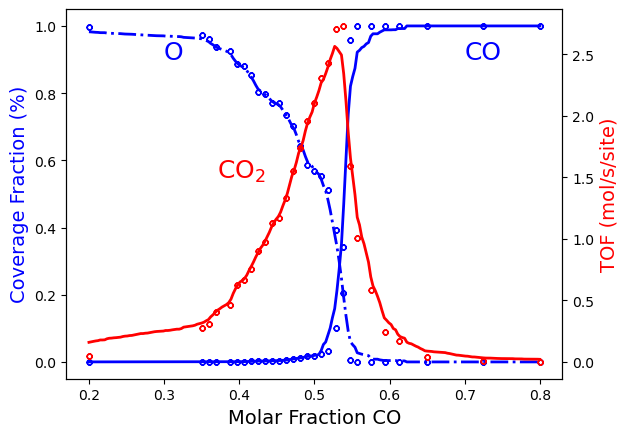

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()

x_CO_model = numpy.linspace(0.2,0.8,201)
ac_O_model,ac_CO_model,TOF_CO2_model = adpML.predict( x_CO_model ).T

ax = plt.axes()
ax.set_xlabel('Molar Fraction CO', fontsize=14)

ax.set_ylabel("Coverage Fraction (%)", color="blue", fontsize=14)
ax.plot(x_CO_model, ac_O_model, color="blue", linestyle="-.", lw=2, zorder=1)
ax.plot(x_CO, ac_O, marker='$\u25EF$', color='blue', markersize=4, lw=0, zorder=1)
ax.plot(x_CO_model, ac_CO_model, color="blue", linestyle="-", lw=2, zorder=2)
ax.plot(x_CO, ac_CO, marker='$\u25EF$', color='blue', markersize=4, lw=0, zorder=1)
plt.text(0.3, 0.9, 'O', fontsize=18, color="blue")
plt.text(0.7, 0.9, 'CO', fontsize=18, color="blue")

ax2 = ax.twinx()
ax2.set_ylabel("TOF (mol/s/site)",color="red", fontsize=14)
ax2.plot(x_CO_model, TOF_CO2_model, color='red', linestyle='-', lw=2, zorder=0)
ax2.plot(x_CO, TOF_CO2, marker='$\u25EF$', color='red', markersize=4, lw=0, zorder=1)
plt.text(0.37, 1.5, 'CO$_2$', fontsize=18, color="red")

plt.show()

We also found three regions involving the two phase transitions, as shown
in the Figure, which are similar to the ones obtained in the example
**Phase Transitions in the ZGB model**. However, as you can see, the
points are not equidistant here. The ADP generated more points for
$x_\text{CO}$ between 0.35 and 0.55, which is likely to represent the
small oscillations that occur there accurately. It is worth noting that
the Surrogate Model has some difficulty reproducing the narrow peak at a
maximum $CO_2$ TOF. Certainly, the model could perform better. Unfortunately,
the only way to do so is by increasing the number of points in the training
set by tuning the ADP parameters' (``algorithmParams``). However, now that
we have the surrogate model, we can quickly obtain the average coverage for
$O*$ and $CO*$ and the $CO_2$ TOF for any $CO$ molar fraction. 

Now, we can close the pyZacros environment:

In [10]:
scm.pyzacros.finish()

[02.02|22:52:41] PLAMS run finished. Goodbye


As a final note, you don't have to recalculate any training points if you load the
surrogate model directly from the disk. As a result, you can apply it to any other
situation, such as e.g., a simulation of reactive computational fluid dynamics (rCFD).
The following code creates the image above exactly, but it starts by reading the
surrogate model from the directory ``plams_workdir/adp.results/``. It can be used
in a separate script.

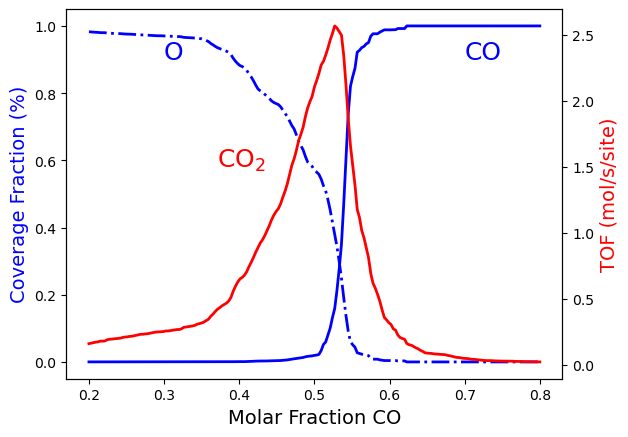

In [15]:
import numpy as np
import adaptiveDesignProcedure as adp
import matplotlib.pyplot as plt

path = "plams_workdir/adp.results/"

x_CO_model = np.linspace(0.2,0.8,201)
ac_O_model,ac_CO_model,TOF_CO2_model = adp.predict( x_CO_model, path ).T

ax = plt.axes()
ax.set_xlabel('Molar Fraction CO', fontsize=14)

ax.set_ylabel("Coverage Fraction (%)", color="blue", fontsize=14)
ax.plot(x_CO_model, ac_O_model, color="blue", linestyle="-.", lw=2, zorder=1)
ax.plot(x_CO_model, ac_CO_model, color="blue", linestyle="-", lw=2, zorder=2)
plt.text(0.3, 0.9, 'O', fontsize=18, color="blue")
plt.text(0.7, 0.9, 'CO', fontsize=18, color="blue")

ax2 = ax.twinx()
ax2.set_ylabel("TOF (mol/s/site)",color="red", fontsize=14)
ax2.plot(x_CO_model, TOF_CO2_model, color='red', linestyle='-', lw=2, zorder=0)
plt.text(0.37, 1.5, 'CO$_2$', fontsize=18, color="red")

plt.show()

By default, the Surrogate Model's file is ``ml_ExtraTrees_forCFD.pkl``. The option
``forestFile`` in the ADP constructor allows you to alter the prefix ``ml_ExtraTrees``.
In the ``adp.predict()`` method, you can provide the complete path to this file, but if
a directory is supplied instead, it will try to discover the proper file inside,
as shown in the lines of code above. 